## Model Training and Interpretability 

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer



In [10]:
df=pd.read_csv('../data/insurance_data.csv')

In [3]:
df

,Unnamed: 0,Province,Zipcode,Gender,Total_Claim,Premium
0,0,C,1003,Female,652.740226,898.493109
1,1,A,1003,Female,1159.389368,1040.563548
2,2,C,1003,Male,729.641413,1137.593249
3,3,C,1003,Female,253.524198,764.332164
4,4,A,1001,Male,938.056933,1349.828367
...,...,...,...,...,...,...
995,995,B,1001,Female,1099.492601,1115.364997
996,996,B,1003,Female,877.886857,1250.101777
997,997,C,1002,Female,776.679394,1090.145906
998,998,C,1003,Male,649.706237,1109.161280


In [ ]:
# # Preprocess data
# df['Margin'] = df['Premium'] - df['Total_Claim']  # Add Margin column
# df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})  # Encode Gender
# df = pd.get_dummies(df, columns=['Province', 'Zipcode'], drop_first=True)  # One-hot encode categorical variables

In [11]:
# Add derived features
df['Margin'] = df['Premium'] - df['Total_Claim']
df['Claim_to_Premium_Ratio'] = df['Total_Claim'] / (df['Premium'] + 1)  # Avoid division by zero
df['Log_Premium'] = np.log1p(df['Premium'])
df['Log_Total_Claim'] = np.log1p(df['Total_Claim'])

In [12]:
# Encode categorical features
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})  # Encode Gender
df = pd.get_dummies(df, columns=['Province', 'Zipcode'], drop_first=True)  # One-hot encode categorical variables

In [14]:
# Define features and target
X = df.drop(['Total_Claim'], axis=1)
y = df['Total_Claim']

In [15]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Train a baseline Random Forest model
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# Evaluate the baseline model
baseline_pred = baseline_model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 149.93015064035671


In [18]:
# Visualize a single tree with limited depth
def visualize_tree(forest_model, feature_names, tree_index=0, max_depth=4):
    """
    Visualize a single tree with a limited depth from the Random Forest model.

    Args:
    - forest_model: The trained Random Forest model.
    - feature_names: List of feature names.
    - tree_index: Index of the tree to visualize.
    - max_depth: Maximum depth of the tree to display.
    """
    tree = forest_model.estimators_[tree_index]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, max_depth=max_depth, filled=True, rounded=True, fontsize=10)
    plt.title(f"Tree {tree_index} from the Random Forest (Max Depth: {max_depth})")
    plt.show()

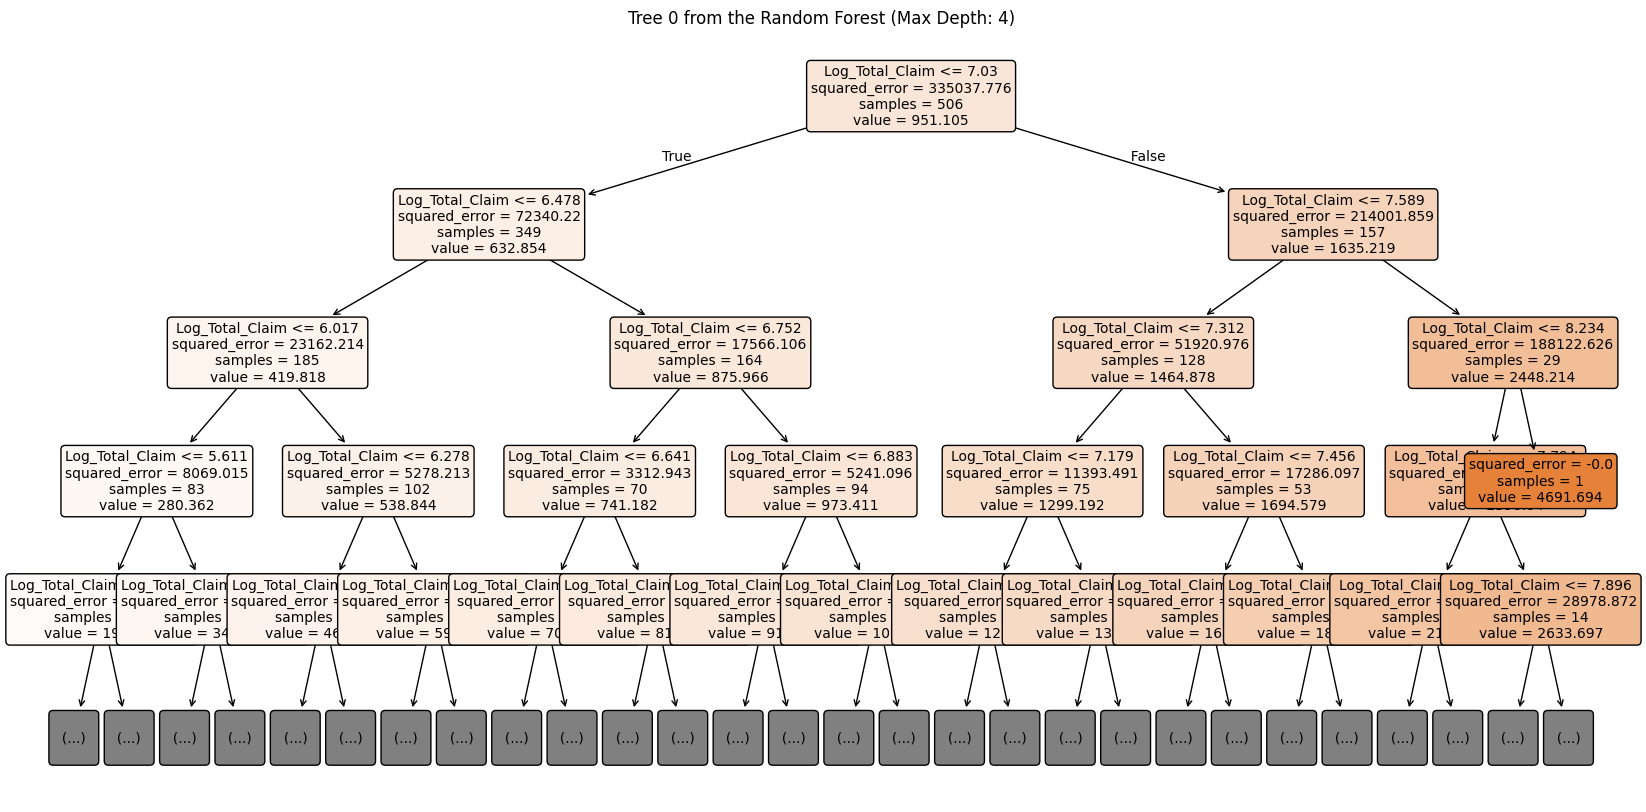

In [19]:
# Example: Visualize the first tree (tree index = 0)
visualize_tree(baseline_model, X.columns.tolist(), tree_index=0, max_depth=4)


###  Model Interpretation with SHAP

SHAP:

Provides global (e.g., summary plot) and local (e.g., force plot) explanations.
Shows how each feature contributes to the overall model prediction.

In [20]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(baseline_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [21]:
shap_values

array([[-0.10427355,  0.16318324,  0.05124067, ..., -0.01896303,
         0.06615309, -0.03010467],
       [ 0.02650825, -0.00091174, -0.0061396 , ..., -0.03499831,
         0.05039391, -0.02067732],
       [-0.0044323 ,  0.02696854, -0.05615395, ..., -0.01169757,
         0.01033425,  0.03565218],
       ...,
       [ 0.02951218,  0.0057619 , -0.00958104, ..., -0.02780656,
         0.0048382 , -0.02419604],
       [ 0.09626222,  0.04201824, -0.02498943, ..., -0.05473422,
         0.09730921,  0.02345511],
       [ 0.03144852, -0.00950534, -0.05268844, ...,  0.04368946,
         0.00805266,  0.07181504]])

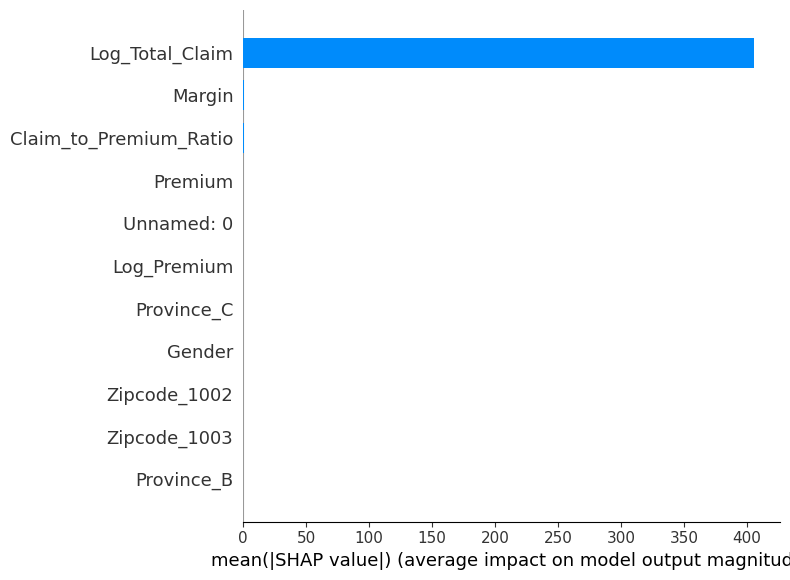

In [22]:
# Visualize feature importance globally
shap.summary_plot(shap_values, X_test, plot_type="bar")


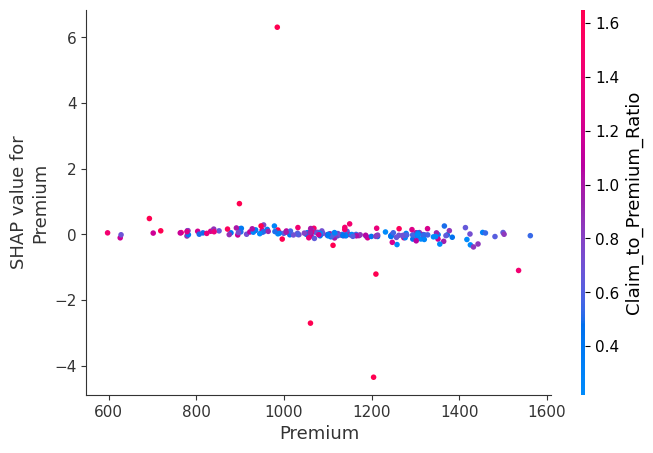

In [23]:
# Visualize how a specific feature affects predictions
shap.dependence_plot("Premium", shap_values, X_test)


In [25]:
# Visualize individual predictions
shap.initjs()  # Initialize the JS visualization in the notebook

# Select an observation to explain (e.g., the first observation in X_test)
observation_index = 2
shap.force_plot(explainer.expected_value, shap_values[observation_index], X_test.iloc[observation_index])


### Model Interpretation with LIME

LIME:

Focuses on local interpretation, explaining the prediction for specific instances.
Useful for understanding individual decisions in detail.

In [27]:
# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression"
)

In [29]:
# Choose an observation to explain
observation_index = 4

# Generate explanation for the observation
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[observation_index].values,
    predict_fn=baseline_model.predict
)

# Visualize the explanation
lime_exp.show_in_notebook()


/home/elias/miniconda/envs/eda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [30]:
# Print the explanation details
print("LIME Explanation for the Observation:")
print(lime_exp.as_list())


LIME Explanation for the Observation:
[('6.25 < Log_Total_Claim <= 6.71', -391.1130315847899), ('1114.58 < Premium <= 1249.74', 31.628973695907565), ('0.00 < Zipcode_1002 <= 1.00', -27.667130295610885), ('0.00 < Gender <= 1.00', -16.759720859014255), ('7.02 < Log_Premium <= 7.13', 13.68998348953895), ('0.45 < Claim_to_Premium_Ratio <= 0.76', -10.765888416643545), ('Zipcode_1003 <= 0.00', -6.889850535217324), ('Province_C <= 0.00', -4.589694640688112), ('241.75 < Unnamed: 0 <= 493.50', -3.321100884617805), ('249.56 < Margin <= 611.82', 1.4569156425922265)]


## LIME Explanation for the Observation (First Instance)

The table below shows how each feature contributes to the prediction for the first observation, as interpreted by LIME:

| **Condition**                       | **Contribution to Prediction** |
|-------------------------------------|--------------------------------|
| `6.71 < Log_Total_Claim <= 7.13`    | +111.70                       |
| `0.76 < Claim_to_Premium_Ratio <= 1.14` | -48.05                       |
| `Gender <= 0.00`                    | +19.68                        |
| `Premium > 1249.74`                 | +16.18                        |
| `Zipcode_1002 <= 0.00`              | -13.39                        |
| `Province_C <= 0.00`                | -8.42                         |
| `Province_B <= 0.00`                | +4.14                         |
| `Zipcode_1003 <= 0.00`              | +2.43                         |
| `Log_Premium > 7.13`                | +2.29                         |

### Key Insights:
1. **Dominant Positive Influence:**
   - `Log_Total_Claim` significantly increases the prediction, contributing +111.70 to the outcome.
   
2. **Dominant Negative Influence:**
   - `Claim_to_Premium_Ratio` decreases the prediction by -48.05, likely indicating a higher premium relative to the claim.

3. **Other Notable Contributions:**
   - Features like `Gender`, `Premium`, and certain zip codes (`Zipcode_1002`, `Zipcode_1003`) have smaller but meaningful impacts on the prediction.
